<a href="https://colab.research.google.com/github/lechemrc/DS-Unit-2-Regression-Classification/blob/master/module3/assignment_regression_classification_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 3

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

Instead, predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`) using a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do exploratory visualizations with Seaborn.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a linear regression model with multiple features.
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- [ ] Add your own stretch goal(s) !
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way (without an excessive amount of formulas or academic pre-requisites).
(That book is good regardless of whether your cultural worldview is inferential statistics or predictive machine learning)
- [ ] Read Leo Breiman's paper, ["Statistical Modeling: The Two Cultures"](https://projecteuclid.org/download/pdf_1/euclid.ss/1009213726)
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html):

> Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:

> - **Convenience and encapsulation.** You only have to call fit and predict once on your data to fit a whole sequence of estimators.
> - **Joint parameter selection.** You can grid search over parameters of all estimators in the pipeline at once.
> - **Safety.** Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

### Importing Data and setting up colab

In [103]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module3')

Requirement already up-to-date: category_encoders in /usr/local/lib/python3.6/dist-packages (2.0.0)
Requirement already up-to-date: pandas-profiling in /usr/local/lib/python3.6/dist-packages (2.3.0)
Requirement already up-to-date: plotly in /usr/local/lib/python3.6/dist-packages (4.1.1)
Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
From https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification
 * branch            master     -> FETCH_HEAD
Already up to date.


In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv('../data/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [106]:
# Make sure SALE_DATE is set to datetime format

df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'], infer_datetime_format=True)
df['SALE_DATE'].describe()

count                   23040
unique                    120
top       2019-01-24 00:00:00
freq                      480
first     2019-01-01 00:00:00
last      2019-04-30 00:00:00
Name: SALE_DATE, dtype: object

In [107]:
print(df.shape)
df.head()

(23040, 21)


,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,CHELSEA,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,nan,R4,"447 WEST 18TH STREET, PH12A",PH12A,"10,011",1,0,1,"10,733","1,979","2,007",2,R4,0,2019-01-01
1,1,FASHION,21 OFFICE BUILDINGS,4,812,68,nan,O5,144 WEST 37TH STREET,NaN,"10,018",0,6,6,"2,962","15,435","1,920",4,O5,0,2019-01-01
2,1,FASHION,21 OFFICE BUILDINGS,4,839,69,nan,O5,40 WEST 38TH STREET,NaN,"10,018",0,7,7,"2,074","11,332","1,930",4,O5,0,2019-01-01
3,1,GREENWICH VILLAGE-WEST,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,nan,R4,"1 SHERIDAN SQUARE, 8C",8C,"10,014",1,0,1,0,500,0,2,R4,0,2019-01-01
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,nan,R1,"20 EAST 65TH STREET, B",B,"10,065",1,0,1,0,"6,406",0,2,R1,0,2019-01-01


#### Checking for null values and cleaning data

In [108]:
# checking for null values
df.isna().sum()

BOROUGH                               0
NEIGHBORHOOD                          0
BUILDING_CLASS_CATEGORY               0
TAX_CLASS_AT_PRESENT                  1
BLOCK                                 0
LOT                                   0
EASE-MENT                         23040
BUILDING_CLASS_AT_PRESENT             1
ADDRESS                               0
APARTMENT_NUMBER                  17839
ZIP_CODE                              1
RESIDENTIAL_UNITS                     1
COMMERCIAL_UNITS                      1
TOTAL_UNITS                           1
LAND_SQUARE_FEET                     53
GROSS_SQUARE_FEET                     1
YEAR_BUILT                           35
TAX_CLASS_AT_TIME_OF_SALE             0
BUILDING_CLASS_AT_TIME_OF_SALE        0
SALE_PRICE                            0
SALE_DATE                             0
dtype: int64

In [109]:
# For the sets with many NaNs, I'm going to drop those columns altogether
# it's likely they wouldn't contribute to the model
df = df.drop(['APARTMENT_NUMBER', 'EASE-MENT'], axis=1)
print(df.shape)
df.isna().sum()

(23040, 19)


BOROUGH                            0
NEIGHBORHOOD                       0
BUILDING_CLASS_CATEGORY            0
TAX_CLASS_AT_PRESENT               1
BLOCK                              0
LOT                                0
BUILDING_CLASS_AT_PRESENT          1
ADDRESS                            0
ZIP_CODE                           1
RESIDENTIAL_UNITS                  1
COMMERCIAL_UNITS                   1
TOTAL_UNITS                        1
LAND_SQUARE_FEET                  53
GROSS_SQUARE_FEET                  1
YEAR_BUILT                        35
TAX_CLASS_AT_TIME_OF_SALE          0
BUILDING_CLASS_AT_TIME_OF_SALE     0
SALE_PRICE                         0
SALE_DATE                          0
dtype: int64

In [110]:
df['BUILDING_CLASS_CATEGORY'].value_counts()

01 ONE FAMILY DWELLINGS                       5061
02 TWO FAMILY DWELLINGS                       4567
10 COOPS - ELEVATOR APARTMENTS                3471
13 CONDOS - ELEVATOR APARTMENTS               3339
03 THREE FAMILY DWELLINGS                     1438
07 RENTALS - WALKUP APARTMENTS                 807
09 COOPS - WALKUP APARTMENTS                   672
15 CONDOS - 2-10 UNIT RESIDENTIAL              421
04 TAX CLASS 1 CONDOS                          418
44 CONDO PARKING                               366
17 CONDO COOPS                                 300
05 TAX CLASS 1 VACANT LAND                     288
22 STORE BUILDINGS                             288
12 CONDOS - WALKUP APARTMENTS                  256
14 RENTALS - 4-10 UNIT                         200
29 COMMERCIAL GARAGES                          147
08 RENTALS - ELEVATOR APARTMENTS               120
30 WAREHOUSES                                  105
21 OFFICE BUILDINGS                             96
31 COMMERCIAL VACANT LAND      

In [111]:
# using data for only single family homes
one_fam = df[df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS']
one_fam.shape

(5061, 19)

In [112]:
pd.options.display.float_format = '{:,.0f}'.format
one_fam.describe()

,BOROUGH,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,SALE_PRICE
count,"5,061","5,061","5,061","5,061","5,061","5,061","5,061","5,061","5,061","5,061","5,061"
mean,4,"6,809",73,"11,041",1,0,1,"1,559","1,942",1,"471,842"
std,1,"3,907",157,501,0,0,0,740,38,0,"928,868"
min,1,17,1,0,0,0,0,0,0,1,0
25%,3,"3,973",21,"10,465",1,0,1,"1,168","1,925",1,0
50%,4,"6,315",41,"11,236",1,0,1,"1,400","1,935",1,"428,000"
75%,4,"9,708",68,"11,413",1,0,1,"1,775","1,955",1,"640,000"
max,5,"16,350","2,780","11,697",2,2,3,"12,618","2,018",1,"30,139,360"


In [113]:
# creating a subset for sale price > $100k but < $2mill
one_fam_subset = one_fam[(one_fam['SALE_PRICE'] > 100000) & 
                         (one_fam['SALE_PRICE'] < 2000000)]
print(one_fam_subset.shape)
one_fam_subset.describe()

(3151, 19)


,BOROUGH,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,SALE_PRICE
count,"3,151","3,151","3,151","3,151","3,151","3,151","3,151","3,151","3,151","3,151","3,151"
mean,4,"6,918",76,"11,027",1,0,1,"1,470","1,944",1,"628,560"
std,1,"3,963",161,483,0,0,0,586,27,0,"292,990"
min,1,21,1,"10,030",0,0,0,0,"1,890",1,"104,000"
25%,3,"4,016",21,"10,461",1,0,1,"1,144","1,925",1,"447,500"
50%,4,"6,301",42,"11,235",1,0,1,"1,360","1,938",1,"568,000"
75%,4,"10,208",69,"11,413",1,0,1,"1,683","1,955",1,"760,000"
max,5,"16,350","2,720","11,697",2,2,3,"7,875","2,018",1,"1,955,000"


#### Splitting the data by datetime to create test and train data

In [114]:
one_fam_subset.shape

(3151, 19)

In [115]:
one_fam_subset['SALE_DATE'].head()

44    2019-01-01
61    2019-01-01
78    2019-01-02
108   2019-01-02
111   2019-01-02
Name: SALE_DATE, dtype: datetime64[ns]

### Exploratory visuals

In [0]:
import seaborn as sns
import plotly.express as px
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [118]:
one_fam_subset.columns

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY',
       'TAX_CLASS_AT_PRESENT', 'BLOCK', 'LOT', 'BUILDING_CLASS_AT_PRESENT',
       'ADDRESS', 'ZIP_CODE', 'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS',
       'TOTAL_UNITS', 'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',
       'TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE',
       'SALE_PRICE', 'SALE_DATE'],
      dtype='object')

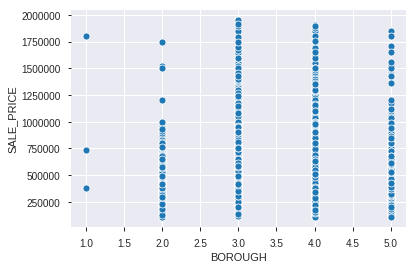

In [119]:
sns.scatterplot(x='BOROUGH', y='SALE_PRICE', data=one_fam_subset)

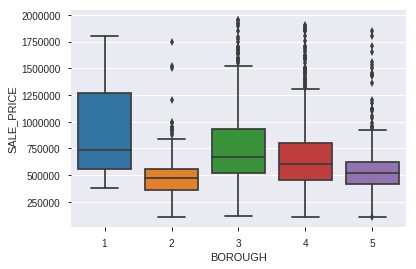

In [120]:
sns.boxplot(x='BOROUGH', y='SALE_PRICE', data=one_fam_subset)

In [0]:
zip_bins = pd.cut(one_fam_subset['ZIP_CODE'], 10)

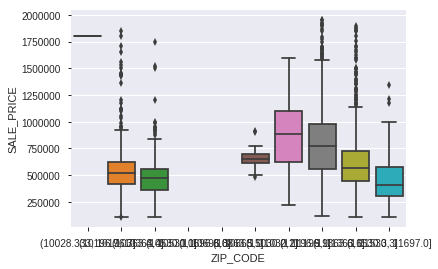

In [122]:
sns.boxplot(x=zip_bins, y='SALE_PRICE', data=one_fam_subset)

### One hot encoding categorical features

In [123]:
# looking at non-numerical data
one_fam_subset.describe(exclude='number')

,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,LAND_SQUARE_FEET,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_DATE
count,3151,3151,3151,3151,3151,3151,3151,3151
unique,183,1,2,13,3135,1035,11,91
top,FLUSHING-NORTH,01 ONE FAMILY DWELLINGS,1,A1,267 DECKER AVENUE,"4,000",A1,2019-01-31 00:00:00
freq,97,3151,3111,1185,2,289,1186,78
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-01 00:00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-04-30 00:00:00


In [124]:
one_fam_subset['BUILDING_CLASS_AT_TIME_OF_SALE'].value_counts()

A1    1186
A5     985
A2     493
A9     239
A0      85
S1      48
A3      43
A8      40
A4      16
A6      15
S0       1
Name: BUILDING_CLASS_AT_TIME_OF_SALE, dtype: int64

In [132]:
one_fam_subset['NEIGHBORHOOD'].describe(exclude='objects')

count               3151
unique               183
top       FLUSHING-NORTH
freq                  97
Name: NEIGHBORHOOD, dtype: object

In [137]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
one_fam_subset['b_class_sale_encoded'] = le.fit_transform(one_fam_subset['BUILDING_CLASS_AT_TIME_OF_SALE']).astype(int)
one_fam_subset['b_class_present_encoded'] = le.fit_transform(one_fam_subset['BUILDING_CLASS_AT_PRESENT']).astype(int)
one_fam_subset.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE,b_class_sale_encoded,b_class_present_encoded
44,3,OCEAN PARKWAY-NORTH,01 ONE FAMILY DWELLINGS,1,5495,801,A9,4832 BAY PARKWAY,"11,230",1,0,1,"6,800","1,325","1,930",1,A9,550000,2019-01-01,8,8
61,4,QUEENS VILLAGE,01 ONE FAMILY DWELLINGS,1,7918,72,A1,80-23 232ND STREET,"11,427",1,0,1,"4,000","2,001","1,940",1,A1,200000,2019-01-01,1,1
78,2,PELHAM PARKWAY SOUTH,01 ONE FAMILY DWELLINGS,1,4210,19,A1,1260 RHINELANDER AVE,"10,461",1,0,1,"3,500","2,043","1,925",1,A1,810000,2019-01-02,1,1
108,3,FLATBUSH-CENTRAL,01 ONE FAMILY DWELLINGS,1,5212,69,A1,469 E 25TH ST,"11,226",1,0,1,"4,000","2,680","1,899",1,A1,125000,2019-01-02,1,1
111,3,FLATBUSH-EAST,01 ONE FAMILY DWELLINGS,1,7930,121,A5,5521 WHITTY LANE,"11,203",1,0,1,"1,710","1,872","1,940",1,A5,620000,2019-01-02,5,5


In [140]:
one_fam_subset['b_class_present_encoded'].dtype

dtype('int64')

### Train Test Split

In [141]:
cutoff = pd.to_datetime('2019-04-01')
train = one_fam_subset[one_fam_subset['SALE_DATE'] < cutoff]
test = one_fam_subset[one_fam_subset['SALE_DATE'] >= cutoff]

train.shape, test.shape

((2507, 21), (644, 21))

#### creating subset of columns

In [142]:
# How many features are there? 
target = 'SALE_PRICE'
features = train.columns.drop(target)
len(features)

20

In [144]:
train_subset = train.select_dtypes('number').dropna(axis='columns')
test_subset = test.select_dtypes('number').dropna(axis='columns')
assert all(train_subset.columns == test_subset.columns)

target = 'SALE_PRICE'
features = train_subset.columns.drop(target)
X_train = train_subset[features]
y_train = train_subset[target]
X_test = test_subset[features]
y_test = test_subset[target]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2507, 12), (2507,), (644, 12), (644,))

In [145]:
train_subset.columns

Index(['BOROUGH', 'BLOCK', 'LOT', 'ZIP_CODE', 'RESIDENTIAL_UNITS',
       'COMMERCIAL_UNITS', 'TOTAL_UNITS', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',
       'TAX_CLASS_AT_TIME_OF_SALE', 'SALE_PRICE', 'b_class_sale_encoded',
       'b_class_present_encoded'],
      dtype='object')

#### KBest feature selection and MAE / R Squared


In [146]:
from sklearn.feature_selection import f_regression, SelectKBest

selector = SelectKBest(score_func = f_regression, k=10)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.fit_transform(X_test, y_test)

X_test_selected.shape, X_test_selected.shape

# I'm honestly unsure of what's going on with this particular error set, though
# it did still select 5 best features for me. 

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning:

invalid value encountered in less_equal

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning:

invalid value encou

((644, 10), (644, 10))

In [147]:
# Which features were selected?

all_names = X_train.columns
selected_mask = selector.get_support()
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features selected:')
for name in selected_names:
  print(name)

Features selected:
BOROUGH
BLOCK
LOT
ZIP_CODE
RESIDENTIAL_UNITS
COMMERCIAL_UNITS
TOTAL_UNITS
GROSS_SQUARE_FEET
YEAR_BUILT
b_class_sale_encoded


In [148]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

model = LinearRegression()
model.fit(X_train_selected, y_train)
y_pred = model.predict(X_test_selected)
mae = mean_absolute_error(y_test, y_pred)
print(f'Test MAE: ${mae:,.0f}')

Test MAE: $166,413


In [149]:
import statsmodels.api as sm
X1 = sm.add_constant(X_train_selected)
result = sm.OLS(y_train, X1).fit()
print(result.rsquared, result.rsquared_adj)

0.37819980236538675 0.37595863224976345


I'm seeing here that KBest isn't helping me much with my selections. My score is quite low, still. Initially I chose 5 features since there are only 18 to choose from. When I went up to 10, my score increased slightly but not by much